In [2]:
library(Seurat)
library(ggplot2)
library(sctransform)
library(Signac)
library(patchwork)
library(MAST)
library(gridExtra)
library(SeuratDisk)
library(BSgenome.Hsapiens.UCSC.hg38)

library(RColorBrewer)

# Get a set of qualitative colors from ColorBrewer
colors_brewer <- brewer.pal(12, "Paired")

# Extend the list by adding more distinguishable colors
colors <- c(
    colors_brewer,
    "#8B0000",  # Dark Red
    "#FF4500",  # Orange Red
    "#2E8B57",  # Sea Green
    "#6A5ACD",  # Slate Blue
    "#DB7093",  # Pale Violet Red
    "#FF69B4",  # Hot Pink
    "#D2691E",  # Chocolate
    "#20B2AA",  # Light Sea Green
    "#FFD700",  # Gold
    "#C71585"   # Medium Violet Red
)

library(JASPAR2020)
library(TFBSTools)
library(chromVAR)
library(Pando)
data(motifs)

# Motif Analysis

## DASA HIC2 VS DASA NT 

In [3]:
# sobj from 07 ngcintegrated = readRDS('{PATH_1}')

In [4]:
Idents(integrated) <- integrated$treatment_and_guidecapture # set idents 
DefaultAssay(integrated) <- "ATAC"

In [5]:
table(Idents(integrated))


     DASA_NT    DASA_HIC2   DASA_PIAS1    DASA_CHD2 DASA_GPBP1L1   DASA_PQBP1 
        2615          375          309          226          131          102 
  DASA_KMT2B    DASA_SLTM  DASA_PLAGL2  DASA_YEATS4    DASA_ADNP    DASA_BRD2 
         210          221           83          121           15           32 
 DASA_ZNF669   DMSO_KMT2B    DMSO_CHD2      DMSO_NT    DMSO_BRD2 DMSO_GPBP1L1 
          79          152           51         1661          148          222 
   DMSO_HIC2   DMSO_PIAS1   DMSO_ZBED6  DMSO_YEATS4  DMSO_ZNF669    DMSO_ADNP 
         216          299          126          241          121           98 
   DMSO_SLTM     DMSO_MNT 
         113           27 

In [6]:
# fix ranges
##### h5seurat loses information and since that was used at one point in the pipeline we no longer have genome info and need to reassign
##### in the future save everything as RDS

# Get the ranges
# Replace the first hyphen with a colon
fixed_ranges <- sub("-", ":", row.names(integrated[["ATAC"]]))

# Create a GRanges object
ranges <- GRanges(fixed_ranges)

# Set the genome info
seqlevelsStyle(ranges) <- "UCSC"
genome(ranges) <- "hg38"

# Replace the ranges in the assay
integrated[["ATAC"]]@ranges <- ranges
#####
#####


In [7]:
# Overrepresented motif using Signac
da_motif <- FindMarkers(
  object = integrated,
  ident.1 = "DASA_HIC2",
  ident.2 = "DASA_NT",
  only.pos = FALSE,
  test.use = 'LR',
  min.pct = 0.05,
  latent.vars = 'nCount_ATAC'
)

sig_peak <- rownames(da_motif[da_motif$p_val_adj <.05,])

# find peaks open in our clusters of interest
open.peaks <- AccessiblePeaks(integrated, idents = c("DASA_HIC2", "DASA_NT"))


In [8]:
integrated <- RegionStats(integrated, genome = BSgenome.Hsapiens.UCSC.hg38)
# match the overall GC content in the peak set
meta.feature <- GetAssayData(integrated, assay = "ATAC", slot = "meta.features")

In [9]:
peaks.matched <- MatchRegionStats(
  meta.feature = meta.feature[open.peaks, ],
  query.feature = meta.feature[sig_peak, ],
  n = 50000
)

Matching GC.percent distribution



In [10]:
# add matrix set
pfm <- getMatrixSet(
  x = JASPAR2020,
  opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
)

# add motif information
integrated <- AddMotifs(
  object = integrated,
  genome = BSgenome.Hsapiens.UCSC.hg38,
  pfm = motifs # changeable
)

da_motif <- FindMotifs(integrated, features = sig_peak, background = peaks.matched)

Building motif matrix

Finding motif positions

Creating Motif object

Warning message in CreateMotifObject(data = motif.matrix, positions = motif.positions, :
“Non-unique motif names supplied, making unique”
Testing motif enrichment in 1076 regions



In [19]:
head(da_motif)

,motif,observed,background,percent.observed,percent.background,fold.enrichment,pvalue,motif.name,p.adjust
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
M09271_2.00,M09271_2.00,517,7988,48.04833,15.976,3.007532,9.855474e-137,NR5A2.6,1.155366e-133
MA1540.1,MA1540.1,512,7843,47.58364,15.686,3.033510,1.453291e-136,NR5A1,1.155366e-133
M05593_2.00,M05593_2.00,463,6802,43.02974,13.604,3.163021,9.381064e-127,NR5A2.4,4.971964e-124
M05590_2.00,M05590_2.00,463,7081,43.02974,14.162,3.038394,4.027024e-120,NR5A2.1,1.600742e-117
MA0141.3,MA0141.3,355,5836,32.99257,11.672,2.826642,3.643487e-78,ESRRB,1.158629e-75
MA0592.3,MA0592.3,398,7257,36.98885,14.514,2.548494,3.627199e-76,ESRRA,9.612078e-74


In [26]:
da_motif[da_motif$motif.name == "TCF4", 1:ncol(da_motif)]

,motif,observed,background,percent.observed,percent.background,fold.enrichment,pvalue,motif.name,p.adjust
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
MA0830.2,MA0830.2,341,14077,31.69145,28.154,1.125646,0.005401369,TCF4,0.04496428


In [27]:
# save
write.csv(da_motif, file = "07_outputs_ngc/07b/07b_DASAHIC2_DASANT_da_pando_motif.csv")

In [22]:
# viz motif 

integrated <- RunChromVAR(
  object = integrated,
  genome = BSgenome.Hsapiens.UCSC.hg38
)

DefaultAssay(integrated) <- 'chromvar'

# look at the activity of Mef2c
p2 <- FeaturePlot(
  object = integrated,
  features = "MA0738.1",
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)
p2

ERROR: Error in UseMethod(generic = "RunChromVAR", object = object): no applicable method for 'RunChromVAR' applied to an object of class "Assay"


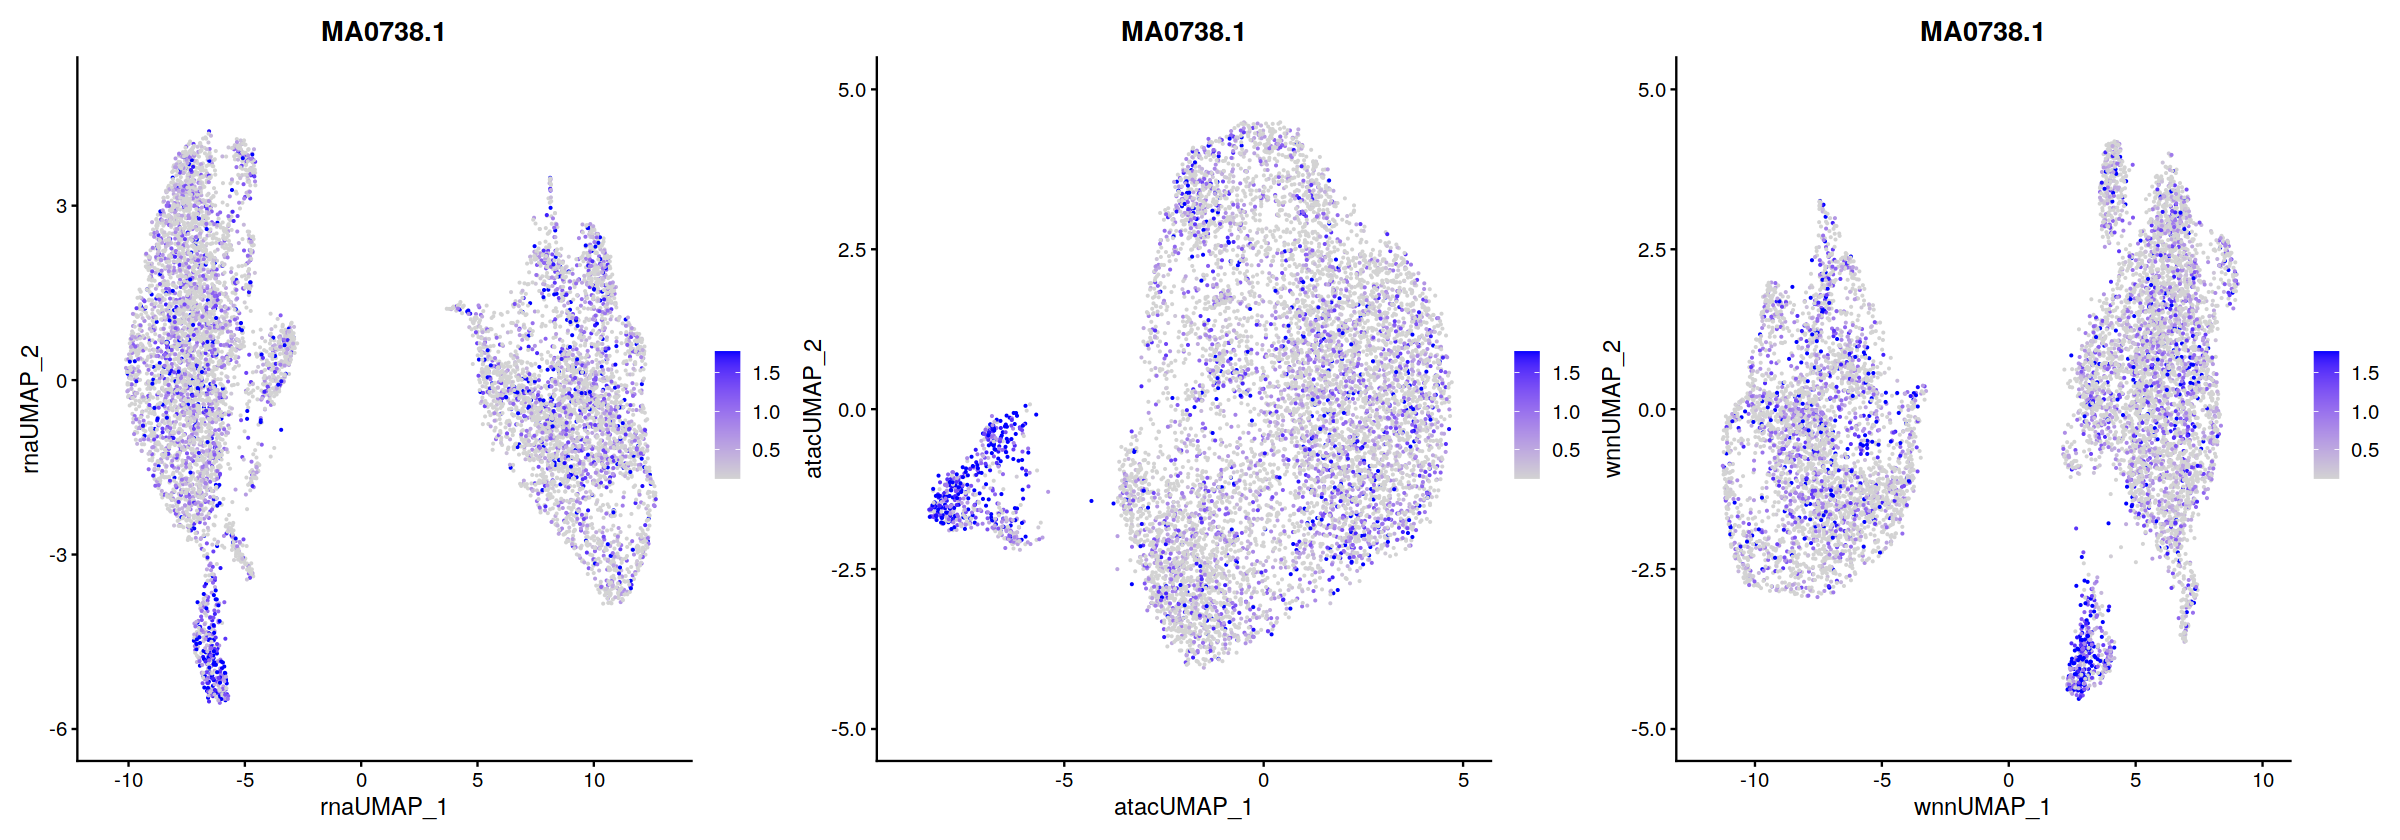

In [23]:
p1 <- FeaturePlot(
  object = integrated,
  features = "MA0738.1",
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1,
  reduction = "rna.umap"
)
p3 <- FeaturePlot(
  object = integrated,
  features = "MA0738.1",
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1,
  reduction = "wnn.umap"
)
options(repr.plot.width = 20, repr.plot.height = 7)
p1|p2|p3


In [16]:
# directly test for differential activity score between cell types
differential.activity <- FindMarkers(
  object = integrated,
  ident.1 = "DASA_HIC2",
  ident.2 = "DASA_NT",
  only.pos = FALSE,
  mean.fxn = rowMeans,
  fc.name = "avg_diff"
)


In [17]:
options(repr.plot.width = 15, repr.plot.height = 10)
MotifPlot(
  object = integrated,
  motifs = rownames(differential.activity)[1:12],
  assay = "ATAC"
)

ERROR: Error in ConvertMotifID.Assay(object = object[[assay]], ...): Cannot run ConvertMotifID on a standard Assay object


In [40]:
# save new sobj
# saveRDS(integrated, file = "07_outputs_ngc/07b/07b_end_sobj.rds")

In [28]:
find_motifs <- function(sobj, ident1 = "", ident2 = "", only_pos = TRUE){
  DefaultAssay(sobj) <- "ATAC"
  # Overrepresented motif using Signac
  da_motif <- FindMarkers(
    object = sobj,
    ident.1 = ident1,
    ident.2 = ident2,
    only.pos = only_pos,
    test.use = 'LR',
    min.pct = 0.05,
    latent.vars = 'nCount_ATAC'
  )

  sig_peak <- rownames(da_motif[da_motif$p_val_adj <.05,])

  # find peaks open in our clusters of interest
  open.peaks <- AccessiblePeaks(sobj, idents = c(ident1, ident2))

  sobj <- RegionStats(sobj, genome = BSgenome.Hsapiens.UCSC.hg38)
  # match the overall GC content in the peak set
  meta.feature <- GetAssayData(sobj, assay = "ATAC", slot = "meta.features")

  peaks.matched <- MatchRegionStats(
    meta.feature = meta.feature[open.peaks, ],
    query.feature = meta.feature[sig_peak, ],
    n = 50000
  )

  # add matrix set
  pfm <- getMatrixSet(
    x = JASPAR2020,
    opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE)
  )

  # add motif information
  sobj <- AddMotifs(
    object = sobj,
    genome = BSgenome.Hsapiens.UCSC.hg38,
    pfm = pfm
  )

  da_motif <- FindMotifs(sobj, features = sig_peak, background = peaks.matched)
  return(da_motif)
}

## DASA HIC2 VS DASA NT ONLY POS

In [29]:
da_motif_only_pos_dasa_hic2_dasa_nt <- find_motifs(integrated, ident1 = "DASA_HIC2", ident2 = "DASA_NT", only_pos = T)

Matching GC.percent distribution

Building motif matrix

Finding motif positions

Creating Motif object

Testing motif enrichment in 1050 regions



In [30]:
# save
write.csv(da_motif_only_pos_dasa_hic2_dasa_nt, file = "07_outputs_ngc/07b/07b_DASAHIC2_DASANT_da_pando_motif_only_pos.csv")

In [2]:
# load
#da_motif_only_pos_dasa_hic2_dasa_nt <- read.csv("07_outputs_ngc/07b/07b_DASAHIC2_DASANT_da_motif_only_pos.csv", row.names)

In [4]:
head(da_motif_only_pos_dasa_hic2_dasa_nt)

,X,motif,observed,background,percent.observed,percent.background,fold.enrichment,pvalue,motif.name,p.adjust
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,MA1540.1,MA1540.1,509,7853,48.47619,15.706,3.086476,1.001785e-139,NR5A1,7.473319e-137
2,MA0505.1,MA0505.1,494,9275,47.04762,18.550,2.536260,1.500782e-100,Nr5a2,5.597917e-98
3,MA0141.3,MA0141.3,353,5771,33.61905,11.542,2.912758,1.582009e-81,ESRRB,3.933930e-79
4,MA0592.3,MA0592.3,396,7219,37.71429,14.438,2.612154,2.719746e-79,ESRRA,5.072327e-77
5,MA0643.1,MA0643.1,344,6102,32.76190,12.204,2.684522,7.677705e-70,Esrrg,1.145514e-67
6,MA0140.2,MA0140.2,378,8554,36.00000,17.108,2.104279,5.293521e-50,GATA1::TAL1,6.581611e-48


In [5]:
da_motif_only_pos_dasa_hic2_dasa_nt[da_motif_only_pos_dasa_hic2_dasa_nt$motif.name == "HIC2", 1:ncol(da_motif_only_pos_dasa_hic2_dasa_nt)]

,X,motif,observed,background,percent.observed,percent.background,fold.enrichment,pvalue,motif.name,p.adjust
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
51,MA0738.1,MA0738.1,212,7798,20.19048,15.596,1.294593,3.561383e-05,HIC2,0.0005209396


## DASA NT VS DASA NT ONLY POS

In [12]:
integrated <- readRDS("07_outputs_ngc/07b/07b_end_sobj.rds")

In [31]:
da_motif_only_pos_dasa_nt_dmso_nt <- find_motifs(integrated, ident1 = "DASA_NT", ident2 = "DMSO_NT", only_pos = T)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [15]:
head(da_motif_only_pos_dasa_nt_dmso_nt)

,motif,observed,background,percent.observed,percent.background,fold.enrichment,pvalue,motif.name,p.adjust
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
MA0140.2,MA0140.2,1551,8369,36.84961,16.738,2.201554,5.377957e-240,GATA1::TAL1,4.011956e-237
MA1513.1,MA1513.1,1001,7006,23.78237,14.012,1.697286,5.699159e-71,KLF15,2.125786e-68
MA1100.2,MA1100.2,1158,8863,27.51247,17.726,1.552097,4.197315e-61,ASCL1,1.043732e-58
MA1653.1,MA1653.1,2198,20199,52.22143,40.398,1.292674,4.646531e-59,ZNF148,8.665780e-57
MA0036.3,MA0036.3,1141,8823,27.10858,17.646,1.536245,1.379230e-57,GATA2,2.057811e-55
MA0506.1,MA0506.1,477,2755,11.33286,5.510,2.056780,4.053945e-54,NRF1,5.040405e-52


In [32]:
# save 
write.csv(da_motif_only_pos_dasa_nt_dmso_nt, file = "07_outputs_ngc/07b/07b_DASANT_DMSONT_da_pando_motif_only_pos.csv")